## 1. Packages

In [45]:
import pickle
import pyranges as pr
import duckdb as db
import numpy as np
import pandas as pd

### 1.1 load snps

In [46]:
parquet_file_path="/lustre1/project/stg_00079/students/tingting/data/GWAS/020results_expansion/Bellenguez_etal_Stage1_result.expanded.parquet"
snps=db.read_parquet(parquet_file_path)

## 2. region markers

In [47]:
dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/030results_cistopic/040dars/markers_dict_pycisTopic_leiden_10_0.5.pkl', 'rb'))

In [48]:
dar_markers

{'0':                             Log2FC  Adjusted_pval Contrast
 chr17:6711652-6712152     0.928064            0.0        0
 chr16:27428371-27428871   0.795657            0.0        0
 chr19:51113065-51113565   0.747530            0.0        0
 chr20:57464820-57465320   0.714707            0.0        0
 chr1:158354187-158354687  0.713424            0.0        0
 ...                            ...            ...      ...
 chr9:85729887-85730387    0.587831            0.0        0
 chr22:36447605-36448105   0.587143            0.0        0
 chr16:29618447-29618947   0.586670            0.0        0
 chr1:17023144-17023644    0.585529            0.0        0
 chr19:41808896-41809396   0.585369            0.0        0
 
 [94 rows x 3 columns],
 '1':                             Log2FC  Adjusted_pval Contrast
 chrY:7274374-7274874      0.736331            0.0        1
 chr10:7468850-7469350     0.704727            0.0        1
 chrY:7273582-7274082      0.682826            0.0        1
 chr

In [49]:
for i in dar_markers.keys():
    print(f"{i}: ", dar_markers[i].shape[0])

0:  94
1:  25
2:  5004
3:  2601
4:  424
5:  4125
6:  5181
7:  3537
8:  2935


In [1]:
# dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/Analysis_fisher_functional/data/DAR_markers_dict.pkl', 'rb'))
# for i in dar_markers.keys():
#     print(f"{i}: ", dar_markers[i].shape[0])

## 3. cluster0

In [12]:
cluster0 = pr.read_bed('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/030results_cistopic/050region_sets/DARs_cell_type/0.bed')

In [18]:
cluster0

,Chromosome,Start,End
0,chr1,8224947,8225447
1,chr1,9432522,9433022
2,chr1,17023144,17023644
3,chr1,22575715,22576215
4,chr1,39530072,39530572
...,...,...,...
89,chr22,34080460,34080960
90,chr22,36447605,36448105
91,chr22,39329073,39329573
92,chr22,40050164,40050664


In [14]:
db.register('cluster0', cluster0.df)

### 3.1 preprocess snps

In [50]:
query = f"""
SELECT Chromosome,
       start_pos,
       snp_pos,
       rsid,
       r_square AS stats
FROM snps

UNION ALL

SELECT Chromosome_AD AS Chromosome, 
       start_pos_AD AS start_pos, 
       snp_pos_AD AS snp_pos, 
       rsid_AD AS rsid, 
       p_value AS stats
FROM snps;
"""

snps_long = db.query(query).df()

In [51]:
snps_long['status'] = pd.to_numeric(snps_long['stats'], errors='coerce')
snps_long['status'] = np.where(snps_long['status'] <= 0.1, 0, snps_long['status']) # 0 lead snp, 1 LD snp
snps_long['status'] = np.where(snps_long['status'] >= 0.8, 1, snps_long['status'])

In [52]:
# Drop rows where 'stats' is NaN (which were originally ".")
snps_long.dropna(subset=['status'], inplace=True)

In [6]:
snps_long.head()

,Chromosome,start_pos,snp_pos,rsid,stats,status
79,chr12,5669458,5669459,rs184127720,1,1.0
80,chr12,5929508,5929509,rs138784520,1,1.0
81,chr12,6477940,6477941,rs187998817,1,1.0
82,chr12,7169756,7169757,.,1,1.0
103,chr9,7480734,7480735,rs138371587,1,1.0


In [53]:
snps_long['status']=snps_long['status'].astype(str)

In [9]:
snps_long.shape

(4211371, 6)

In [54]:
sum(snps_long.duplicated())

1201027

In [10]:
snps_long.head()

,Chromosome,start_pos,snp_pos,rsid,stats,status
79,chr12,5669458,5669459,rs184127720,1,1.0
80,chr12,5929508,5929509,rs138784520,1,1.0
81,chr12,6477940,6477941,rs187998817,1,1.0
82,chr12,7169756,7169757,.,1,1.0
103,chr9,7480734,7480735,rs138371587,1,1.0


In [11]:
db.register('snps_long_view', snps_long)

### 3.2 merge

In [21]:
query=f"""
SELECT
    pk.Chromosome,
    pk.Start,
    pk.End,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.stats, 
    s.status
FROM
    snps_long s
JOIN
    cluster0 pk ON s.chromosome = pk.Chromosome
                      AND s.start_pos BETWEEN pk.Start AND pk.End;
"""
snps_peaks_joined_table=db.query(query)

In [22]:
query=f"""
SELECT * FROM snps_peaks_joined_table LIMIT 10
"""
db.query(query)

┌──────────────────────────────────┬───────────┬───────────┬───────────┬───────────┬──────────────┬──────────┬─────────┐
│            Chromosome            │   Start   │    End    │ start_pos │  snp_pos  │     rsid     │  stats   │ status  │
│ enum('chr1', 'chr10', 'chr11',…  │   int32   │   int32   │   int64   │   int64   │   varchar    │ varchar  │ varchar │
├──────────────────────────────────┼───────────┼───────────┼───────────┼───────────┼──────────────┼──────────┼─────────┤
│ chr2                             │  85677652 │  85678152 │  85677715 │  85677716 │ rs527938047  │ 0.09925  │ 0.0     │
│ chr19                            │  41808896 │  41809396 │  41809126 │  41809127 │ rs193110478  │ 0.002967 │ 0.0     │
│ chr17                            │   6711652 │   6712152 │   6711883 │   6711884 │ rs562124329  │ 0.002191 │ 0.0     │
│ chr1                             │ 158354187 │ 158354687 │ 158354622 │ 158354623 │ rs2873587    │ 0.03409  │ 0.0     │
│ chr22                         

In [23]:
query=f"""
SELECT * FROM snps_peaks_joined_table
"""
cluster0_snps=db.query(query).df()

In [24]:
cluster0_snps.shape

(40, 8)

In [27]:
cluster0_snps

,Chromosome,Start,End,start_pos,snp_pos,rsid,stats,status
0,chr22,39329073,39329573,39329224,39329225,rs149953174,0.01274,0.0
1,chr15,89936033,89936533,89936424,89936425,rs1357257603,0.01116,0.0
2,chr16,10558971,10559471,10559223,10559224,rs567567417,0.02655,0.0
3,chr9,85729887,85730387,85730385,85730386,rs74640032,0.009691,0.0
4,chr22,29217190,29217690,29217461,29217462,rs9620872,0.008455,0.0
5,chr9,85729887,85730387,85730152,85730153,rs138231684,0.008009,0.0
6,chr10,79949204,79949704,79949522,79949523,rs12219080,0.007605,0.0
7,chr2,240960550,240961050,240960985,240960986,rs7591322,0.07072,0.0
8,chr2,85677652,85678152,85678025,85678026,rs569343323,0.07006,0.0
9,chr14,22422225,22422725,22422464,22422465,rs562765291,0.06994,0.0


In [25]:
sum(cluster0_snps.duplicated())

0

In [26]:
# 38 lead snps, 2 buddies
cluster0_snps['status'].value_counts()

0.0    38
1.0     2
Name: status, dtype: int64

## 4. cluster1

In [46]:
cluster1 = pr.read_bed('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/030results_cistopic/050region_sets/DARs_cell_type/1.bed')
db.register('cluster1', cluster1.df)
query=f"""
SELECT
    pk.Chromosome,
    pk.Start,
    pk.End,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.stats
FROM
    snps_long s
JOIN
    cluster1 pk ON s.chromosome = pk.Chromosome
                      AND s.start_pos BETWEEN pk.Start AND pk.Start + 500;
"""
snps_peaks_joined_table=db.query(query)
query=f"""
SELECT * FROM snps_peaks_joined_table
"""
cluster1_snps=db.query(query).df()
cluster1_snps.shape

(31, 7)

## 5. automate

In [55]:
clusters=list(dar_markers.keys())
clusters

['0', '1', '2', '3', '4', '5', '6', '7', '8']

In [56]:
for cluster in clusters:
    data = pr.read_bed(f'/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/030results_cistopic/050region_sets/DARs_cell_type/{cluster}.bed')
    db.register(f'cluster', data.df)
    query=f"""
    SELECT
        pk.Chromosome,
        pk.Start,
        pk.End,
        s.start_pos,
        s.snp_pos,
        s.rsid,
        s.stats,
        s.status
    FROM
        snps_long s
    JOIN
        cluster pk ON s.chromosome = pk.Chromosome
                        AND s.start_pos BETWEEN pk.Start AND pk.End;
    """
    snps_peaks_joined_table=db.query(query)
    query=f"""
    SELECT * FROM snps_peaks_joined_table
    """
    cluster_snps=db.query(query).df()
    duplicated=sum(cluster_snps.duplicated())
    print(f"Cluster duplicates: {duplicated}")
    if duplicated>0:
        cluster_snps=cluster_snps.drop_duplicates()
    cluster_snps.to_csv(f'/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/cluster_snps/{cluster}.csv', index=False)
    print(f"number of cluster {cluster} SNPs: {cluster_snps.shape[0]}")
    print(f"cluster {cluster}: {cluster_snps['status'].value_counts()}")


Cluster duplicates: 0
number of cluster 0 SNPs: 40
cluster 0: 0.0    38
1.0     2
Name: status, dtype: int64
Cluster duplicates: 24
number of cluster 1 SNPs: 7
cluster 1: 0.0    6
1.0    1
Name: status, dtype: int64
Cluster duplicates: 407
number of cluster 2 SNPs: 2668
cluster 2: 0.0    2191
1.0     477
Name: status, dtype: int64
Cluster duplicates: 279
number of cluster 3 SNPs: 1612
cluster 3: 0.0    1345
1.0     267
Name: status, dtype: int64
Cluster duplicates: 189
number of cluster 4 SNPs: 290
cluster 4: 0.0    235
1.0     55
Name: status, dtype: int64
Cluster duplicates: 746
number of cluster 5 SNPs: 2308
cluster 5: 0.0    1889
1.0     419
Name: status, dtype: int64
Cluster duplicates: 490
number of cluster 6 SNPs: 3007
cluster 6: 0.0    2465
1.0     542
Name: status, dtype: int64
Cluster duplicates: 224
number of cluster 7 SNPs: 1935
cluster 7: 0.0    1614
1.0     321
Name: status, dtype: int64
Cluster duplicates: 184
number of cluster 8 SNPs: 1621
cluster 8: 0.0    1385
1.0    

In [57]:
# Initialize the dictionary to store the results
clusters_data = {}

# List of clusters (assuming it is predefined)
clusters = ['0', '1', '2', '3', '4', '5', '6', '7', '8']

# Iterate over each cluster
for cluster in clusters:
    # Read the BED file for the cluster
    data = pr.read_bed(f'/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/030results_cistopic/050region_sets/DARs_cell_type/{cluster}.bed')
    
    # Register the data to DuckDB
    db.register(f'cluster', data.df)
    
    # Perform the join query
    query = f"""
    SELECT
        pk.Chromosome,
        pk.Start,
        pk.End,
        s.start_pos,
        s.snp_pos,
        s.rsid,
        s.stats,
        s.status
    FROM
        snps_long s
    JOIN
        cluster pk ON s.chromosome = pk.Chromosome
                        AND s.start_pos BETWEEN pk.Start AND pk.End;
    """
    snps_peaks_joined_table = db.query(query)
    
    # Convert to DataFrame
    query = "SELECT * FROM snps_peaks_joined_table"
    cluster_snps = db.query(query).df()
    
    # Handle duplicates
    duplicated = sum(cluster_snps.duplicated())
    print(f"Cluster duplicates: {duplicated}")
    if duplicated > 0:
        cluster_snps = cluster_snps.drop_duplicates()
    
    # Save to CSV
    cluster_snps.to_csv(f'/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/cluster_snps/{cluster}.csv', index=False)
    
    # Print the number of SNPs
    total_snps = cluster_snps.shape[0]
    print(f"number of cluster {cluster} SNPs: {total_snps}")
    
    # Print and collect the status counts
    status_counts = cluster_snps['status'].value_counts().to_dict()
    print(f"cluster {cluster}: {status_counts}")
    
    # Populate the clusters_data dictionary
    clusters_data[cluster] = {
        'total_snps': total_snps,
        'stats': status_counts
    }

print(clusters_data)


Cluster duplicates: 0
number of cluster 0 SNPs: 40
cluster 0: {'0.0': 38, '1.0': 2}
Cluster duplicates: 24
number of cluster 1 SNPs: 7
cluster 1: {'0.0': 6, '1.0': 1}
Cluster duplicates: 407
number of cluster 2 SNPs: 2668
cluster 2: {'0.0': 2191, '1.0': 477}
Cluster duplicates: 279
number of cluster 3 SNPs: 1612
cluster 3: {'0.0': 1345, '1.0': 267}
Cluster duplicates: 189
number of cluster 4 SNPs: 290
cluster 4: {'0.0': 235, '1.0': 55}
Cluster duplicates: 746
number of cluster 5 SNPs: 2308
cluster 5: {'0.0': 1889, '1.0': 419}
Cluster duplicates: 490
number of cluster 6 SNPs: 3007
cluster 6: {'0.0': 2465, '1.0': 542}
Cluster duplicates: 224
number of cluster 7 SNPs: 1935
cluster 7: {'0.0': 1614, '1.0': 321}
Cluster duplicates: 184
number of cluster 8 SNPs: 1621
cluster 8: {'0.0': 1385, '1.0': 236}
{'0': {'total_snps': 40, 'stats': {'0.0': 38, '1.0': 2}}, '1': {'total_snps': 7, 'stats': {'0.0': 6, '1.0': 1}}, '2': {'total_snps': 2668, 'stats': {'0.0': 2191, '1.0': 477}}, '3': {'total_snp

In [58]:
total_snps= [clusters_data[cluster]['total_snps'] for cluster in clusters]

In [59]:
total_snps

[40, 7, 2668, 1612, 290, 2308, 3007, 1935, 1621]

In [61]:
dars=[]
for i in dar_markers.keys():
    print(f"{i}: ", dar_markers[i].shape[0])
    dars.append(dar_markers[i].shape[0])

0:  94
1:  25
2:  5004
3:  2601
4:  424
5:  4125
6:  5181
7:  3537
8:  2935


In [62]:
dars

[94, 25, 5004, 2601, 424, 4125, 5181, 3537, 2935]

Percentages:  [42.5531914893617, 28.000000000000004, 53.317346123101515, 61.97616301422529, 68.39622641509435, 55.95151515151515, 58.03898861223702, 54.70737913486005, 55.229982964224874]


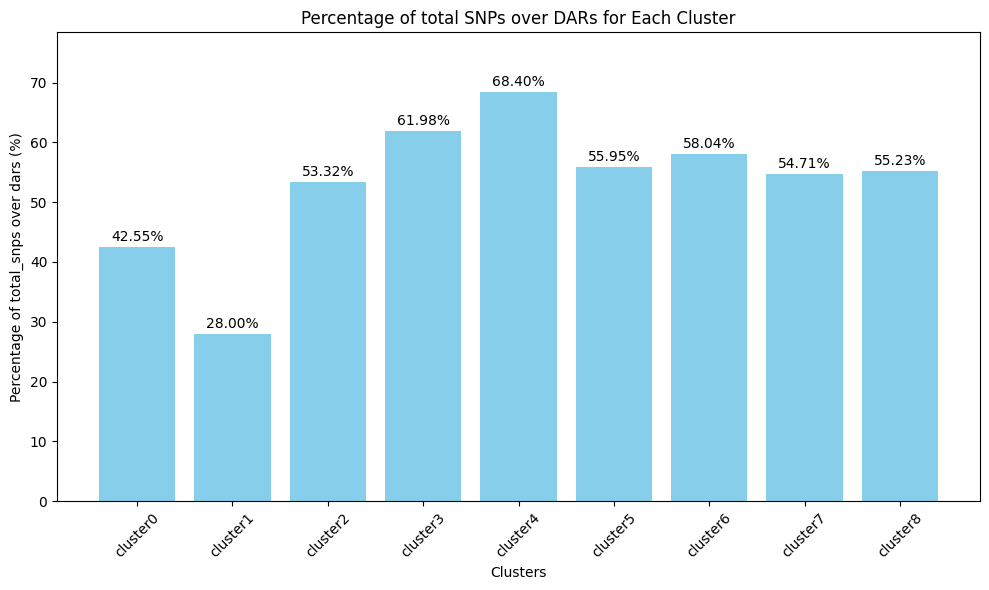

In [64]:
total_snps = [40, 7, 2668, 1612, 290, 2308, 3007, 1935, 1621]
dars = [94, 25, 5004, 2601, 424, 4125, 5181, 3537, 2935]

# Calculate the percentage using list comprehension
percentages = [(a / b) * 100 for a, b in zip(total_snps, dars)]

print("Percentages: ", percentages)

# Define cluster labels
clusters = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8']

# Plotting the percentages
plt.figure(figsize=(10, 6))
plt.bar(clusters, percentages, color='skyblue')
plt.xlabel('Clusters')
plt.ylabel('Percentage of total_snps over dars (%)')
plt.title('Percentage of total SNPs over DARs for Each Cluster')
plt.xticks(rotation=45)
plt.ylim(0, max(percentages) + 10)  # Adjust y-axis limit for better visibility
plt.tight_layout()

# Adding the percentage values on top of the bars
for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

plt.show()

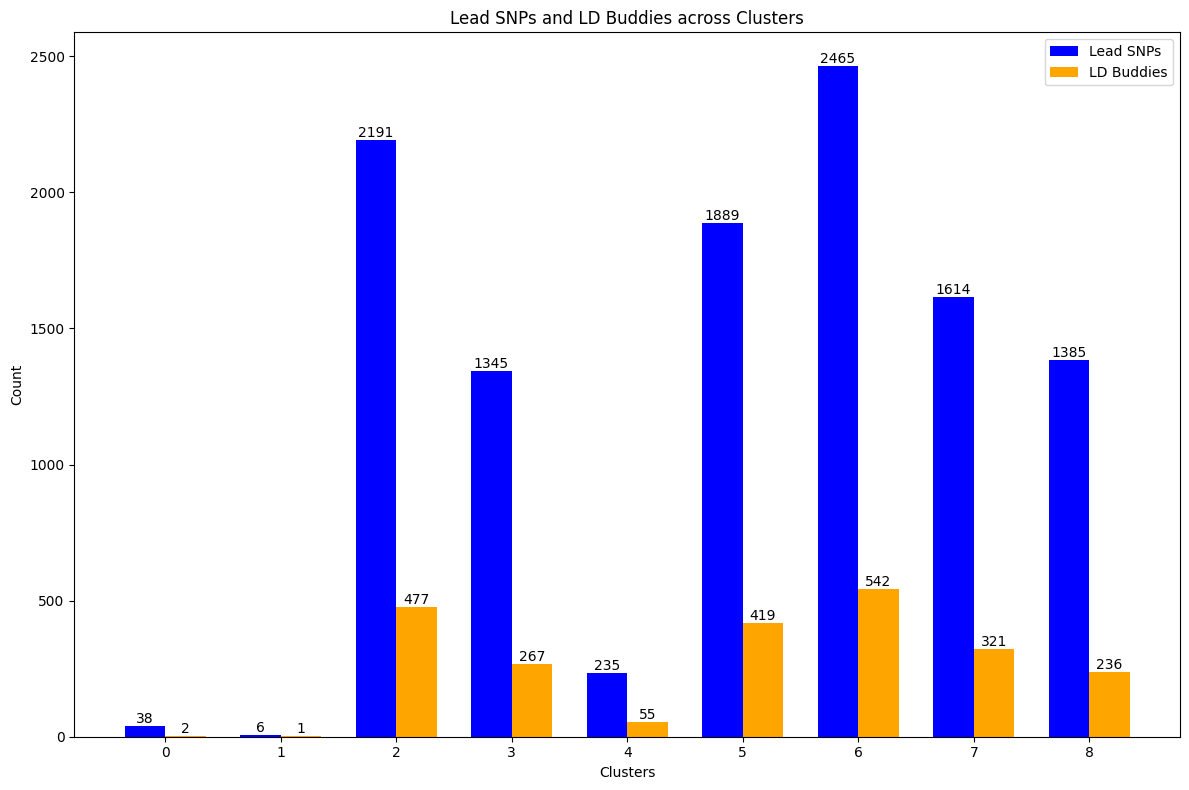

In [37]:
import matplotlib.pyplot as plt
clusters = list(clusters_data.keys())
lead_snps = [clusters_data[cluster]['stats']['0.0'] for cluster in clusters]
ld_buddies = [clusters_data[cluster]['stats']['1.0'] for cluster in clusters]

x = np.arange(len(clusters))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the bars
bars1 = ax.bar(x - width/2, lead_snps, width, label='Lead SNPs', color='blue')
bars2 = ax.bar(x + width/2, ld_buddies, width, label='LD Buddies', color='orange')

# Adding labels, title and custom x-axis tick labels
ax.set_xlabel('Clusters')
ax.set_ylabel('Count')
ax.set_title('Lead SNPs and LD Buddies across Clusters')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()

# Adding the text labels on the bars
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)

fig.tight_layout()

plt.show()

## 6. consensus regions

In [12]:
consensus_regions = pr.read_bed('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/030results_cistopic/010consensus_peak_calling/consensus_regions.bed')

In [67]:
consensus_regions

,Chromosome,Start,End,Name,Score,Strand
0,chr1,818833,819333,3_peak_7,0.299094,.
1,chr1,821218,821718,3_peak_9,0.247526,.
2,chr1,825591,826091,3_peak_10,0.195958,.
3,chr1,858590,859090,1_peak_7,0.180043,.
4,chr1,890638,891138,1_peak_9,0.535943,.
...,...,...,...,...,...,...
346414,chrY,3004671,3005171,"1_peak_112627g,1_peak_112627h,0_peak_106534e,0...",0.883198,.
346415,chrY,21289473,21289973,"4_peak_95397a,4_peak_95397b,2_peak_116813b,1_p...",2.049447,.
346416,chrY,19745059,19745559,"4_peak_95392a,4_peak_95392b,0_peak_106607c,0_p...",3.081761,.
346417,chrY,12661449,12661949,"3_peak_121587a,0_peak_106578a,0_peak_106578b,6...",3.285013,.


In [14]:
db.register('consensus_regions', consensus_regions.df)

In [15]:
query=f"""
SELECT
    pk.Chromosome,
    pk.Start,
    pk.End,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.stats
FROM
    snps_long s
JOIN
    consensus_regions pk ON s.chromosome = pk.Chromosome
                      AND s.start_pos BETWEEN pk.Start AND pk.End;
"""
snps_peaks_joined_table=db.query(query)
query=f"""
SELECT * FROM snps_peaks_joined_table
"""
consensus_snps=db.query(query).df()
consensus_snps.shape

(258439, 7)

In [70]:
query=f"""
SELECT count(*) FROM snps_long
"""
db.query(query)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      4211371 │
└──────────────┘

## 7. consensus regions folder 10

In [16]:
# 10bp
consensus_regions = pr.read_bed('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/10/030results_cistopic/010consensus_peak_calling/consensus_regions.bed')
db.register('consensus_regions', consensus_regions.df)
query=f"""
SELECT
    pk.Chromosome,
    pk.Start,
    pk.End,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.stats
FROM
    snps_long s
JOIN
    consensus_regions pk ON s.chromosome = pk.Chromosome
                      AND s.start_pos BETWEEN pk.Start AND pk.End;
"""
snps_peaks_joined_table=db.query(query)
query=f"""
SELECT * FROM snps_peaks_joined_table
"""
consensus_snps=db.query(query).df()
consensus_snps.shape # (17179, 7)


(17179, 7)

In [9]:
consensus_regions

,Chromosome,Start,End,Name,Score,Strand
0,chr1,807783,807793,1_peak_2,0.267801,.
1,chr1,807998,808008,3_peak_4,0.165114,.
2,chr1,808208,808218,0_peak_3,0.381407,.
3,chr1,817353,817363,2_peak_2,8.603799,.
4,chr1,818114,818124,1_peak_4b,0.137620,.
...,...,...,...,...,...,...
1092236,chrY,14328942,14328952,"5_peak_164413,3_peak_121597",0.570761,.
1092237,chrY,2935112,2935122,"1_peak_112626a,3_peak_121542a",3.035082,.
1092238,chrY,8523279,8523289,"3_peak_121563,4_peak_95357",1.207946,.
1092239,chrY,8535967,8535977,"3_peak_121564b,1_peak_112658",5.013837,.


In [17]:
consensus_regions = pr.read_bed('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/11/030results_cistopic/010consensus_peak_calling/consensus_regions.bed')
db.register('consensus_regions', consensus_regions.df)
query=f"""
SELECT
    pk.Chromosome,
    pk.Start,
    pk.End,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.stats
FROM
    snps_long s
JOIN
    consensus_regions pk ON s.chromosome = pk.Chromosome
                      AND s.start_pos BETWEEN pk.Start AND pk.End;
"""
snps_peaks_joined_table=db.query(query)
query=f"""
SELECT * FROM snps_peaks_joined_table
"""
consensus_snps=db.query(query).df()
consensus_snps.shape # (275596, 7)


(275596, 7)

## 8. summary

In [18]:
consensus_regions_08 = pr.read_bed('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/08/030results_cistopic/010consensus_peak_calling/consensus_regions.bed')
consensus_regions_10 = pr.read_bed('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/10/030results_cistopic/010consensus_peak_calling/consensus_regions.bed')
consensus_regions_11 = pr.read_bed('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/11/030results_cistopic/010consensus_peak_calling/consensus_regions.bed')

In [23]:
print(consensus_regions_08.df.shape)
print(consensus_regions_10.df.shape)
print(consensus_regions_11.df.shape)

(346419, 6)
(1092241, 6)
(365116, 6)


In [25]:
## SNPs in consensus regions
summary={
    'Method 1': 258439/346419,
    'Method 2': 17179/1092241,
    'Method 3': 275596/365116
}


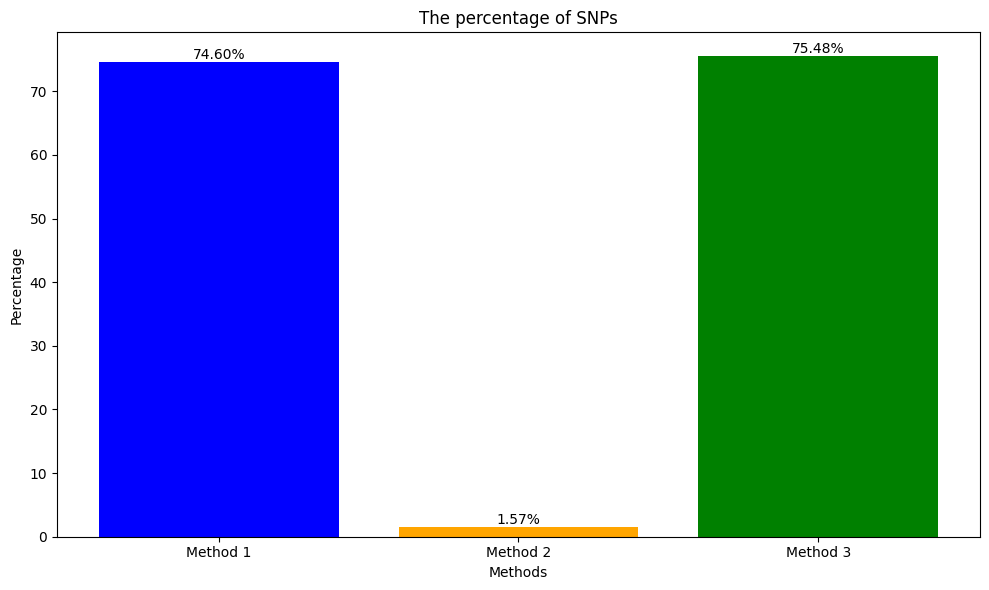

In [31]:
import matplotlib.pyplot as plt

# Extracting keys and values
methods = list(summary.keys())
percentages = [value * 100 for value in summary.values()]  # Convert to percentages

# Creating the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, percentages, color=['blue', 'orange', 'green'])

# Adding labels, title and custom tick labels
plt.xlabel('Methods')
plt.ylabel('Percentage')
plt.title('The percentage of SNPs')
plt.xticks(methods)

# Adding the text labels on the bars
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}%', va='bottom', ha='center')

plt.tight_layout()
plt.show()
